In [1]:
from pyspark.sql import SparkSession

import os

spark = SparkSession.builder \
        .master("local") \
        .appName("PSTAT_131_Final_Project") \
        .getOrCreate()
sc = spark.sparkContext

Data Import

In [2]:
## Reading dataset in and printing first record
from pyspark.sql.functions import lit
df_2014 = spark.read.csv("2014_Financial_Data.csv", inferSchema = True, header = True)
df_2015 = spark.read.csv("2015_Financial_Data.csv", inferSchema = True, header = True)
df_2016 = spark.read.csv("2016_Financial_Data.csv", inferSchema = True, header = True)
df_2017 = spark.read.csv("2017_Financial_Data.csv", inferSchema = True, header = True)
df_2018 = spark.read.csv("2018_Financial_Data.csv", inferSchema = True, header = True)

df_2014 = df_2014.drop("2015 PRICE VAR [%]")
df_2014 = df_2014.withColumn('Year', lit(2014))

df_2015 = df_2015.drop("2016 PRICE VAR [%]")
df_2015 = df_2015.withColumn('Year', lit(2015))

df_2016 = df_2016.drop("2017 PRICE VAR [%]")
df_2016 = df_2016.withColumn('Year', lit(2016))

df_2017 = df_2017.drop("2018 PRICE VAR [%]")
df_2017 = df_2017.withColumn('Year', lit(2017))

df_2018 = df_2018.drop("2019 PRICE VAR [%]")
df_2018 = df_2018.withColumn('Year', lit(2018))

## Merging all datasets together
financial_df = df_2014.unionByName(df_2015).unionByName(df_2016).unionByName(df_2017).unionByName(df_2018)
print(financial_df.count())
financial_df.take(1)

22077


[Row(_c0='PG', Revenue=74401000000.0, Revenue Growth=-0.0713, Cost of Revenue=39030000000.0, Gross Profit=35371000000.0, R&D Expenses=0.0, SG&A Expense=21461000000.0, Operating Expenses=21461000000.0, Operating Income=13910000000.0, Interest Expense=709000000.0, Earnings before Tax=14494000000.0, Income Tax Expense=2851000000.0, Net Income - Non-Controlling int=142000000.0, Net Income - Discontinued ops=-1127000000.0, Net Income=11643000000.0, Preferred Dividends=0.0, Net Income Com=11643000000.0, EPS=4.19, EPS Diluted=4.01, Weighted Average Shs Out=2705960276.0, Weighted Average Shs Out (Dil)=2705960276.0, Dividend per Share=2.448, Gross Margin=0.4754, EBITDA Margin=0.247, EBIT Margin=0.2043, Profit Margin=0.156, Free Cash Flow margin=0.1359, EBITDA=18344000000.0, EBIT=15203000000.0, Consolidated Income=11785000000.0, Earnings Before Tax Margin=0.1948, Net Profit Margin=0.1565, Cash and cash equivalents=8558000000.0, Short-term investments=2128000000.0, Cash and short-term investments

In [3]:
financial_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Revenue Growth: double (nullable = true)
 |-- Cost of Revenue: double (nullable = true)
 |-- Gross Profit: double (nullable = true)
 |-- R&D Expenses: double (nullable = true)
 |-- SG&A Expense: double (nullable = true)
 |-- Operating Expenses: double (nullable = true)
 |-- Operating Income: double (nullable = true)
 |-- Interest Expense: double (nullable = true)
 |-- Earnings before Tax: double (nullable = true)
 |-- Income Tax Expense: double (nullable = true)
 |-- Net Income - Non-Controlling int: double (nullable = true)
 |-- Net Income - Discontinued ops: double (nullable = true)
 |-- Net Income: double (nullable = true)
 |-- Preferred Dividends: double (nullable = true)
 |-- Net Income Com: double (nullable = true)
 |-- EPS: double (nullable = true)
 |-- EPS Diluted: double (nullable = true)
 |-- Weighted Average Shs Out: double (nullable = true)
 |-- Weighted Average Shs Out (Dil): double (nullab

Data Exploration

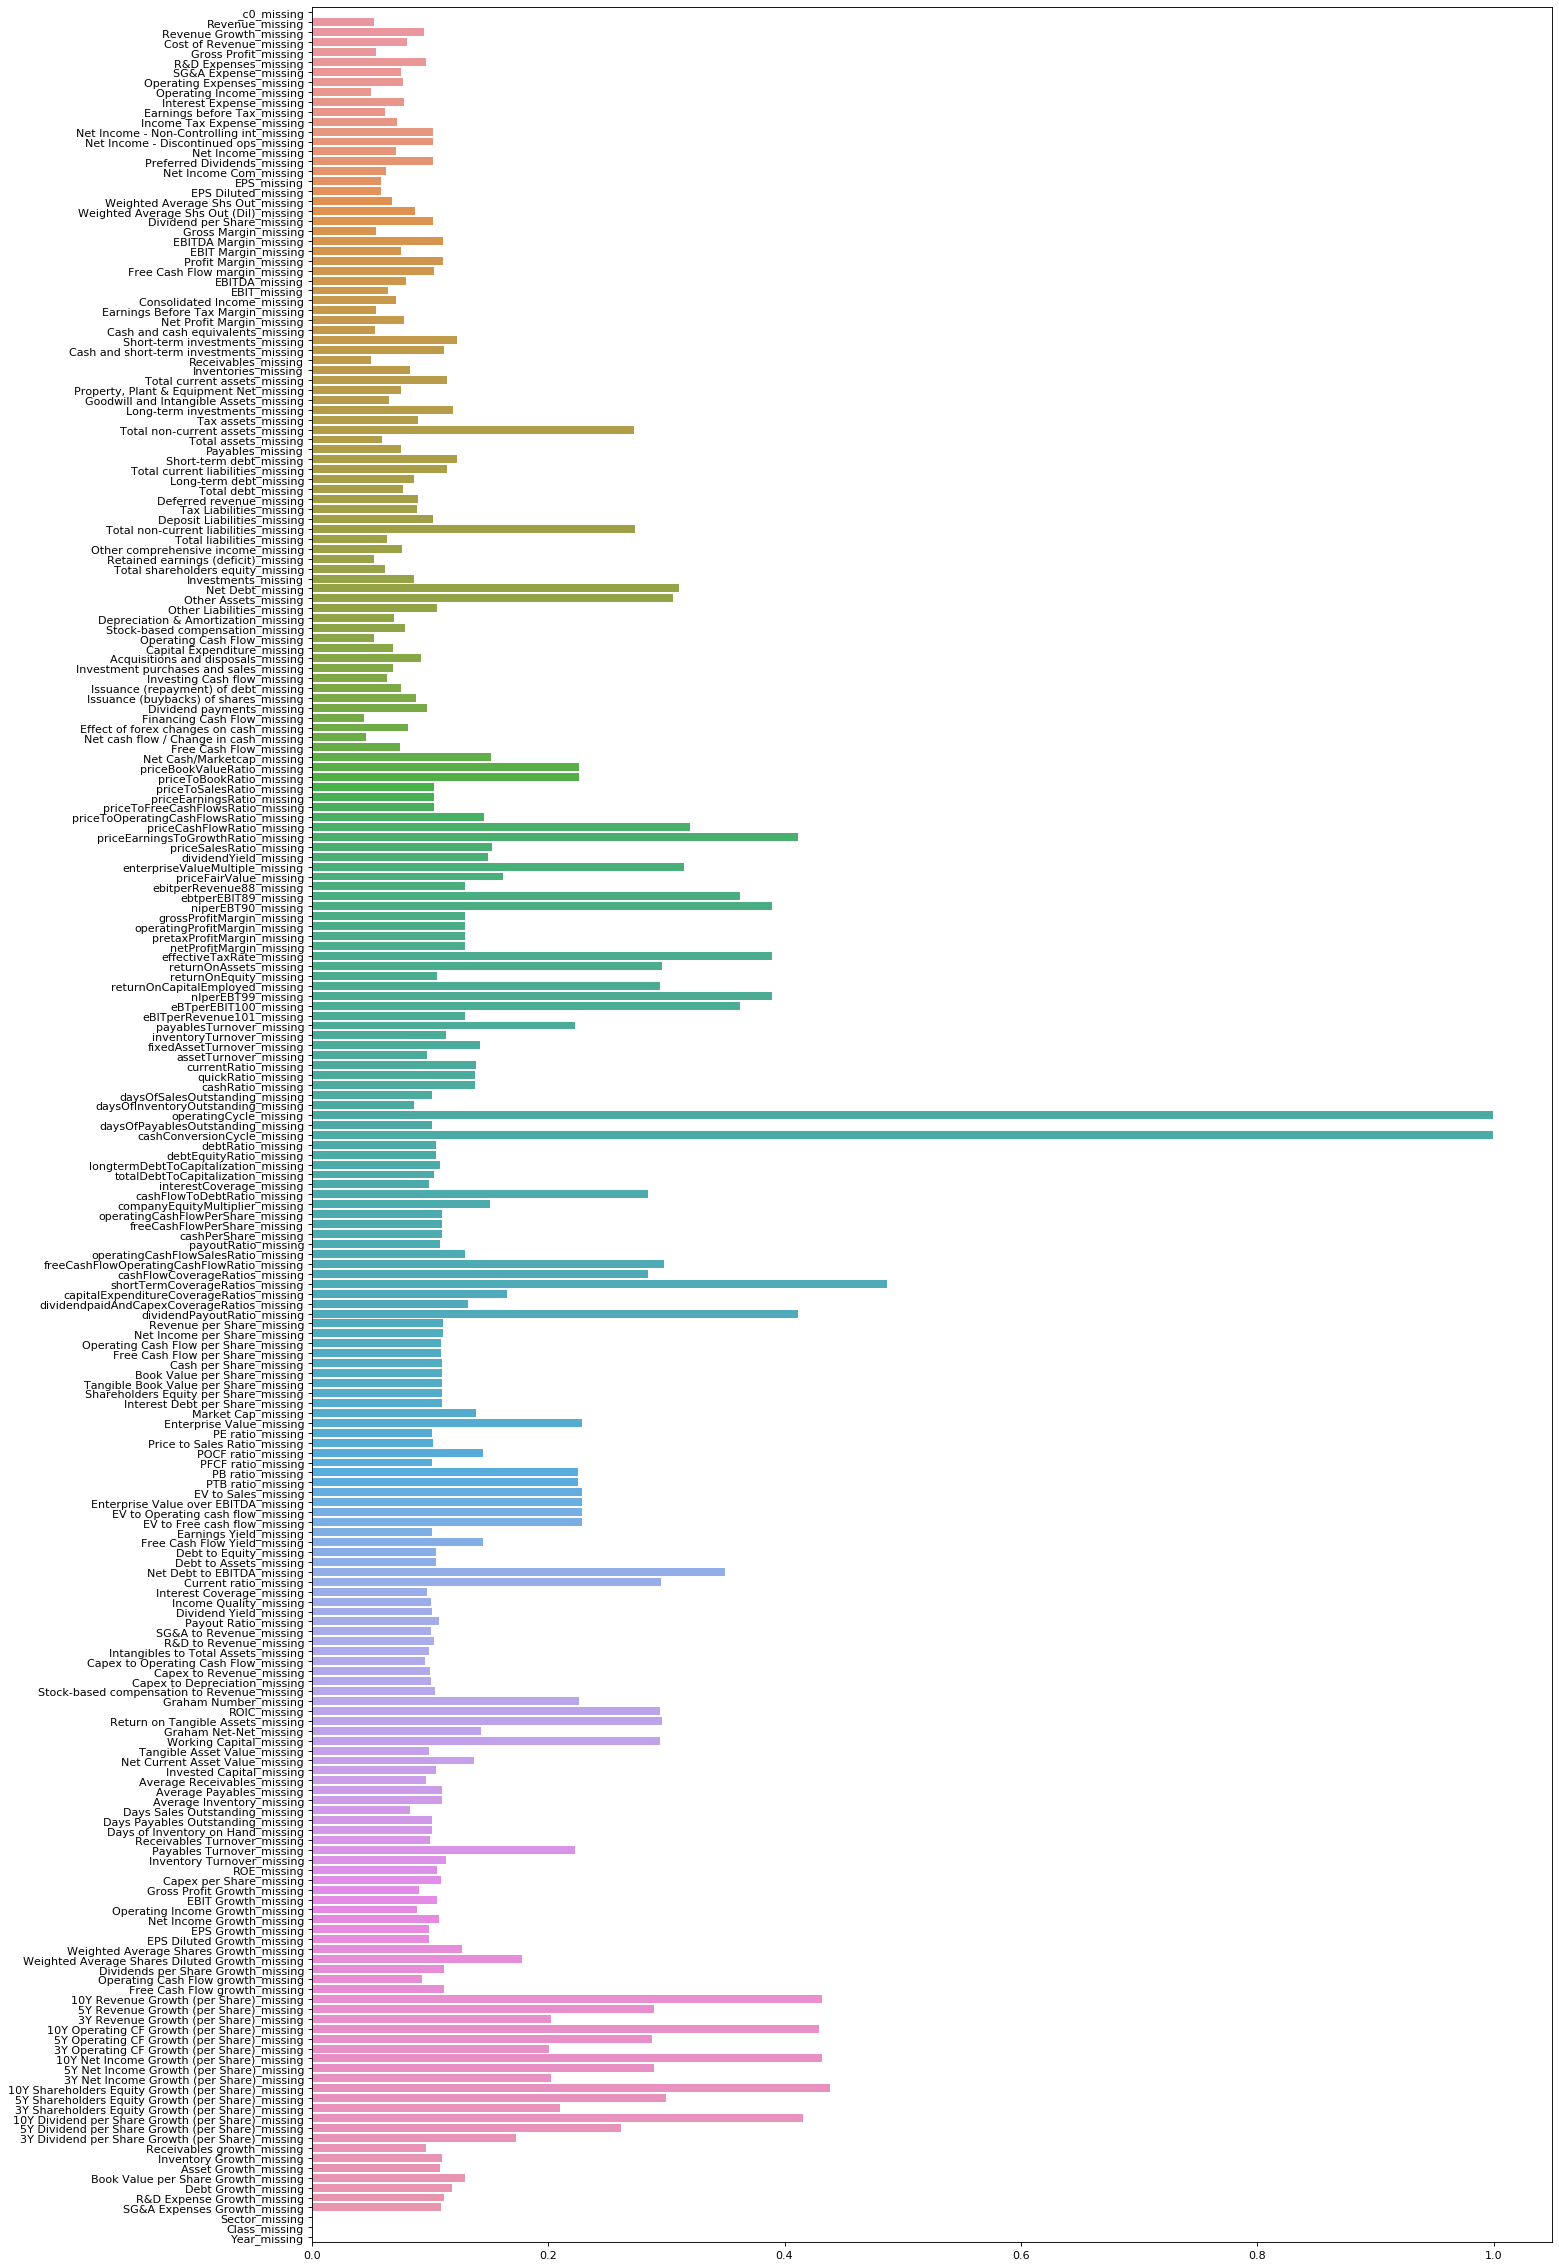

In [4]:
## Plotting percentage of missing values per column

from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

num_missing = financial_df.agg(*[(1 - (F.count(c) / F.count('*'))).alias(c + '_missing') for c in financial_df.columns])
percentages = num_missing.rdd.flatMap(lambda row: row)
column_names = num_missing.columns
percentages = percentages.collect()


figure(num=None, figsize=(20,37), dpi=80, facecolor='w', edgecolor='r')
sns.barplot(x=percentages, y = column_names)
plt.show()

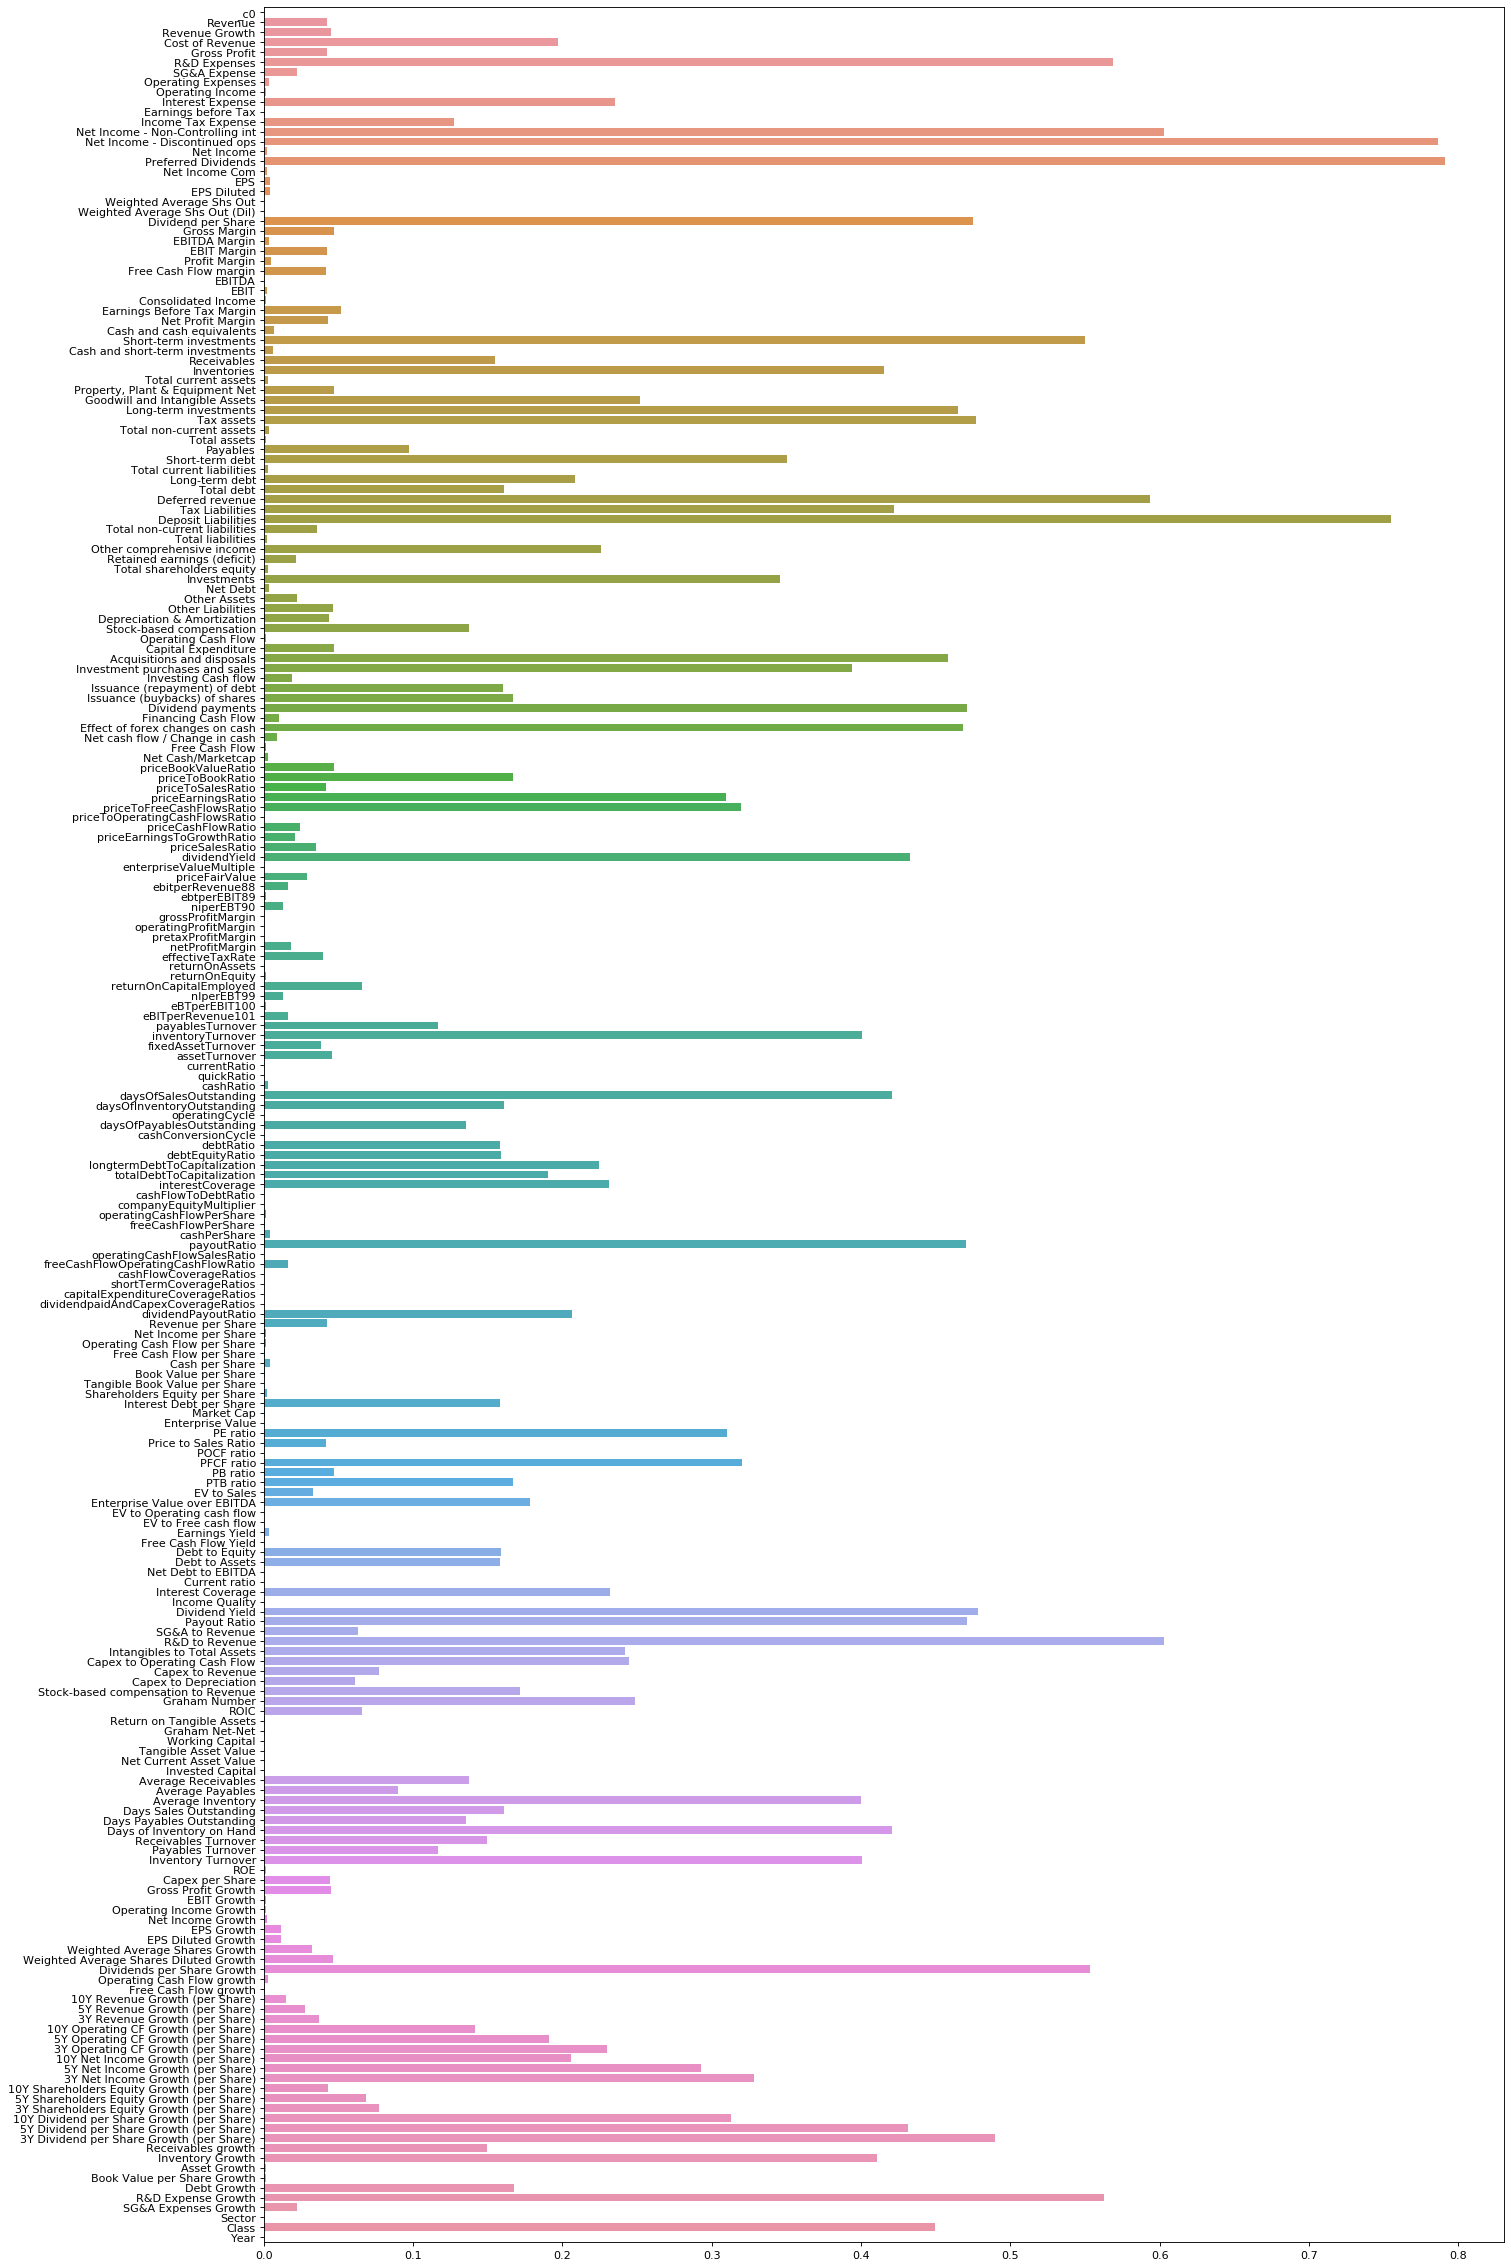

In [5]:
## Plotting percentage of 0.0 values per column

nums_zero = financial_df.select([ (F.count(F.when(df_2014[c] == 0, c))/F.count('*')).alias(c) for c in financial_df.columns])
percentages_zero = nums_zero.rdd.flatMap(lambda row: row)
column_names = nums_zero.columns
percentages_zero = percentages_zero.collect()


figure(num=None, figsize=(20,37), dpi=80, facecolor='w', edgecolor='r')
sns.barplot(x=percentages_zero, y = column_names)
plt.show()

In [6]:
## dataframe showing percentages of missing values and 0.0 values in each column
preprocess_df = spark.createDataFrame(zip(column_names, percentages, percentages_zero), schema = ["column_names","percentage_missing","percentage_zero"])
preprocess_df.show(225)

+--------------------+--------------------+--------------------+
|        column_names|  percentage_missing|     percentage_zero|
+--------------------+--------------------+--------------------+
|                 _c0|                 0.0|                 0.0|
|             Revenue| 0.05304162703265847|0.042442360828011054|
|      Revenue Growth| 0.09457806767223809| 0.04488834533677583|
|     Cost of Revenue| 0.08021923268560038| 0.19685645694614304|
|        Gross Profit| 0.05467228337183494| 0.04230647279974634|
|        R&D Expenses| 0.09684286814331655|  0.5687366942972324|
|        SG&A Expense| 0.07559903972460025| 0.02260270870136341|
|  Operating Expenses| 0.07709380803551202|0.003668976763147...|
|    Operating Income|0.049870906373148505|0.001449472301490...|
|    Interest Expense| 0.07786384019567871|  0.2352221769262128|
| Earnings before Tax| 0.06178375685102144|0.001222992254382...|
|  Income Tax Expense|  0.0719300629614531|    0.12723649046519|
|Net Income - Non-...| 0.

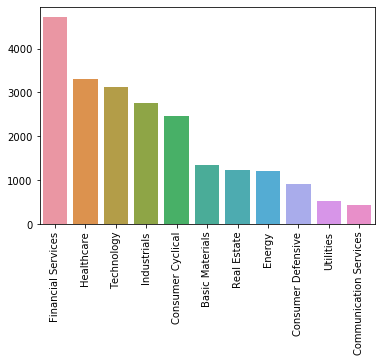

In [15]:
## Plotting number of observations in each sector
sector_aggregates = financial_df.groupBy("Sector").agg(F.count("Sector")).orderBy('count(Sector)', ascending = False)
sector_names = sector_aggregates.select("Sector")
sector_counts = sector_aggregates.select("count(Sector)")

sector_names = sector_names.rdd.flatMap(lambda row: row).collect()
sector_counts = sector_counts.rdd.flatMap(lambda row: row).collect()

sns.barplot(sector_names, sector_counts)
plt.xticks(rotation=90)
plt.show()

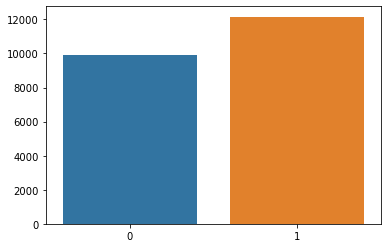

In [17]:
## Exploring number of observations in each class of response variable
class_data = financial_df.groupBy("Class").agg(F.count("Class"))
counts = class_data.select("count(Class)")
classes = class_data.select("Class")

classes = classes.rdd.flatMap(lambda row: row).collect()
counts = counts.rdd.flatMap(lambda row: row).collect()

sns.barplot(classes, counts)
plt.show()

Preprocessing Step 

In [8]:
## Filtering out columns that have more than 30% missing values and 50% 0.0 values

na_filtered = preprocess_df.filter( (preprocess_df['percentage_missing'] < 0.30) & (preprocess_df['percentage_zero'] < 0.50))
na_filtered.show(na_filtered.count())
vars_to_keep = na_filtered.select("column_names").rdd.flatMap(lambda row: row).collect()

+--------------------+--------------------+--------------------+
|        column_names|  percentage_missing|     percentage_zero|
+--------------------+--------------------+--------------------+
|                 _c0|                 0.0|                 0.0|
|             Revenue| 0.05304162703265847|0.042442360828011054|
|      Revenue Growth| 0.09457806767223809| 0.04488834533677583|
|     Cost of Revenue| 0.08021923268560038| 0.19685645694614304|
|        Gross Profit| 0.05467228337183494| 0.04230647279974634|
|        SG&A Expense| 0.07559903972460025| 0.02260270870136341|
|  Operating Expenses| 0.07709380803551202|0.003668976763147...|
|    Operating Income|0.049870906373148505|0.001449472301490...|
|    Interest Expense| 0.07786384019567871|  0.2352221769262128|
| Earnings before Tax| 0.06178375685102144|0.001222992254382...|
|  Income Tax Expense|  0.0719300629614531|    0.12723649046519|
|          Net Income| 0.07088825474475702|0.001947728405127...|
|      Net Income Com| 0.

In [9]:
## loop that creates a subset of the dataframe for each sector, obtains average for each column and stores it in notebook
## then replaces null values with sector averages and appends the dataframe to the list subsets
## imputed_df is created by union of each dataframe saved in the list subsets

from pyspark.sql.functions import col

filtered_df = financial_df.select([col for col in financial_df.columns if (col in vars_to_keep or col == "Class")])

subsets=[]

for sector in sector_names:
    subset_df = filtered_df.where(col("Sector") == sector)
    means = subset_df.agg(*[F.mean(c).alias(c)for c in subset_df.columns]).toPandas().to_dict('records')[0]
    imputed_subset = subset_df.fillna(means)
    subsets.append(imputed_subset)
    
imputed_df = subsets[0].unionByName(subsets[1]).unionByName(subsets[2]).unionByName(subsets[3])  \
            .unionByName(subsets[4]).unionByName(subsets[5]).unionByName(subsets[6]) \
            .unionByName(subsets[7]).unionByName(subsets[8]).unionByName(subsets[9]) \
            .unionByName(subsets[10])

In [20]:
## Counting number of null values per row, now each row has 0 null values

imputed_df.rdd.map(lambda row: (row['_c0'], sum([c == None for c in row]))).take(10)

[('BAC', 0),
 ('WFC', 0),
 ('AIG', 0),
 ('C', 0),
 ('MS', 0),
 ('JPM', 0),
 ('BBD', 0),
 ('AXP', 0),
 ('V', 0),
 ('KEY', 0)]

In [21]:
imputed_df = imputed_df.drop("_c0")

Data Splitting

In [22]:
## Using years 2014-2017 as training data and the 2018 data as the test set
## This leads to about a 80/20 train/test split
train_data = imputed_df.where( (col("Year") == 2014) | (col("Year") == 2015) | (col("Year") == 2016) | (col("Year") == 2017))
test_data = imputed_df.where(col("Year") ==  2018)
print("Number of observations in training set: {}, Number of observations in test set: {}".format(train_data.count(), test_data.count()))
print("Percentage of train data of whole dataset:{}%".format( 100*train_data.count()/imputed_df.count() ))

Number of observations in training set: 17685, Number of observations in test set: 4392
Percentage of train data of whole dataset:80.10599266204648%


In [23]:
train_data.cache()
train_data.take(1)

[Row(Revenue=85894000000.0, Revenue Growth=-0.0343, Cost of Revenue=0.0, Gross Profit=85894000000.0, SG&A Expense=74720000000.0, Operating Expenses=75656000000.0, Operating Income=10238000000.0, Interest Expense=0.0, Earnings before Tax=7963000000.0, Income Tax Expense=2443000000.0, Net Income=5520000000.0, Net Income Com=4476000000.0, EPS=0.43, EPS Diluted=0.42, Weighted Average Shs Out=10516450466.0, Weighted Average Shs Out (Dil)=10527818000.0, Dividend per Share=0.12, Gross Margin=1.0, EBITDA Margin=0.122, EBIT Margin=0.0927, Profit Margin=0.052000000000000005, Free Cash Flow margin=0.3585, EBITDA=10485000000.0, EBIT=7963000000.0, Consolidated Income=5520000000.0, Earnings Before Tax Margin=0.0927, Net Profit Margin=0.0643, Cash and cash equivalents=337922000000.0, Cash and short-term investments=13687209548.369677, Receivables=61845000000.0, Inventories=0.0, Total current assets=24680978593.562313, Property, Plant & Equipment Net=10049000000.0, Goodwill and Intangible Assets=77919

Model Building/Evaluation

In [24]:
## First, a random forest model is fit to do feature selection
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MaxAbsScaler
from pyspark.ml import Pipeline  
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Fitting RandomForestClassifier model in order to explore feature importance

predictor_features = train_data.drop("Class", "Year", "Sector").columns
predictor_features.append("SectorIndex")

stringIndexer = StringIndexer(inputCol = "Sector", outputCol = "SectorIndex")
assembler = VectorAssembler(inputCols=predictor_features, outputCol="features")
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
rf = RandomForestClassifier(labelCol="Class", featuresCol="scaledFeatures", numTrees = 10, seed = 1)

pipeline = Pipeline(stages = [stringIndexer, assembler, scaler, rf])

model = pipeline.fit(train_data)

## Extracting feature importance from the model and inserting data into a dataframe
import pandas as pd
model_importance = pd.DataFrame(model.stages[-1].featureImportances.toArray(), columns=["values"])
features_col = pd.Series(predictor_features)
model_importance["predictor_features"] = features_col
model_importance = model_importance.sort_values(by = "values", ascending = False)
importance_df = spark.createDataFrame(model_importance)

## Filtering out features that have 0 importance or have no contribution to the models predictive ability
importance_df_zeros_filtered = importance_df.filter(importance_df["values"] != 0)
importance_df_zeros_filtered.show(importance_df.count())

+--------------------+--------------------+
|              values|  predictor_features|
+--------------------+--------------------+
| 0.04321667490775672|dividendpaidAndCa...|
|  0.0365897923046905|operatingCashFlow...|
| 0.03641693198605098|Operating Cash Fl...|
|0.033200090346997904|              EBITDA|
| 0.03095640348287703|EV to Operating c...|
|0.030808096894695415| Operating Cash Flow|
|0.030527585657892282|priceToFreeCashFl...|
| 0.02883974757577329|capitalExpenditur...|
|0.027323901470957406| Consolidated Income|
|0.025240004378851048|   Net Profit Margin|
| 0.01641429761663312|         Receivables|
|0.015407597962139283|Effect of forex c...|
|0.015063494930210225|          Market Cap|
| 0.01494903884331437| priceBookValueRatio|
|0.014727811476301794|           PTB ratio|
|0.014291374187016717|         EPS Diluted|
|0.014105667512436151|Days Payables Out...|
|0.013684672216847734|Weighted Average ...|
|0.013320131485353544|          Net Income|
|0.013012623473184682|   Payable

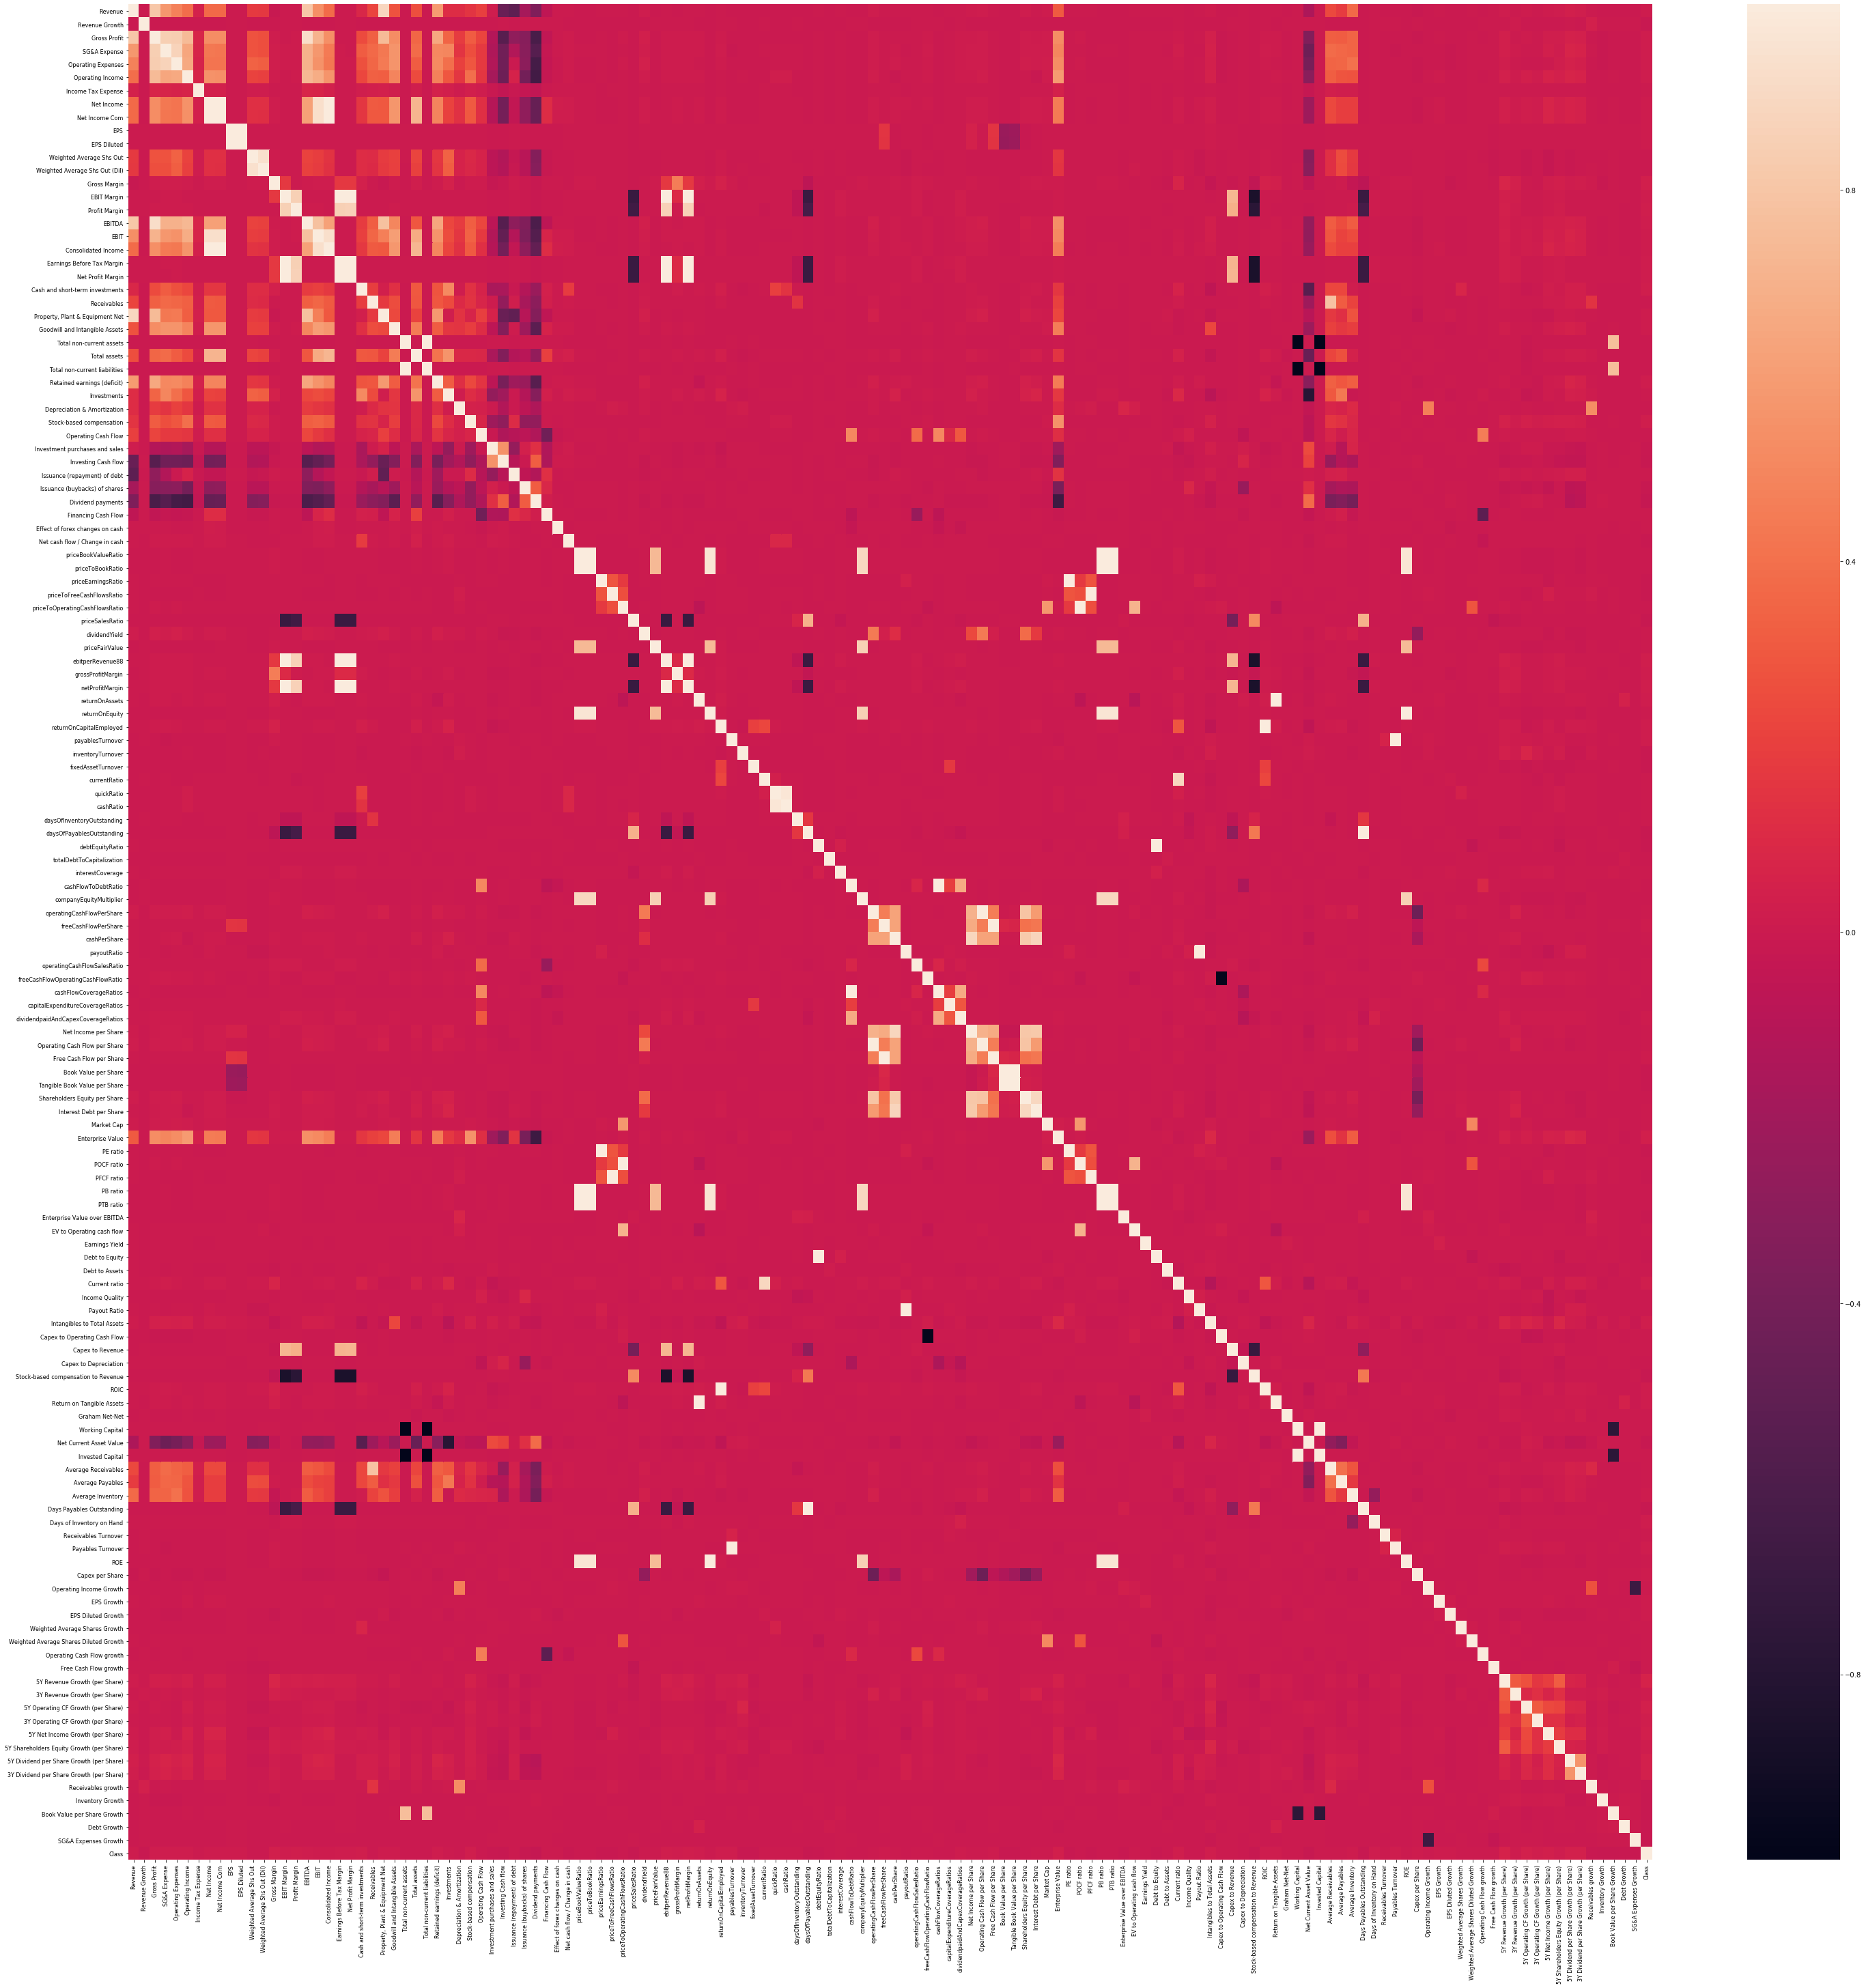

In [25]:
## Building the correlation matrix to see if there is any collinearity between remaining features
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

important_features = importance_df_zeros_filtered.select("predictor_features").rdd.flatMap(lambda row : row).collect()
important_features.append("Class")
correlation_vars = train_data.select([col for col in financial_df.columns if (col in important_features)])

assembler = VectorAssembler(inputCols = correlation_vars.columns, outputCol = "correlation_features")
vector_df = assembler.transform(correlation_vars).select("correlation_features")
matrix = Correlation.corr(vector_df, "correlation_features").collect()[0][0]
correlation_matrix = matrix.toArray().tolist()

correlation_df = spark.createDataFrame(correlation_matrix, correlation_vars.columns)

## Plotting the correlation heatmap from the correlation matrix
import numpy as np
fig, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(correlation_matrix)
ticks = np.arange(len(correlation_matrix)) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(correlation_vars.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(correlation_vars.columns, rotation=360, fontsize=8)
plt.show()

In [26]:
## Finding the collinearity between variables that have strong correlation
l = len(important_features)

for i in range(l-1):
    for j in range(l-1):
        if (i != j):
            if (correlation_matrix[i][j] > 0.7) or (correlation_matrix[i][j] < -0.7):
                print("Feature 1({}): {} Feature 2({}): {}() Correlation Between Features: {}".format(i,important_features[i],j,important_features[j],correlation_matrix[i][j]))

Feature 1(0): dividendpaidAndCapexCoverageRatios Feature 2(2): Operating Cash Flow per Share() Correlation Between Features: 0.8079949988821069
Feature 1(0): dividendpaidAndCapexCoverageRatios Feature 2(16): Days Payables Outstanding() Correlation Between Features: 0.8090813484657127
Feature 1(0): dividendpaidAndCapexCoverageRatios Feature 2(23): Profit Margin() Correlation Between Features: 0.8975532055000086
Feature 1(2): Operating Cash Flow per Share Feature 2(0): dividendpaidAndCapexCoverageRatios() Correlation Between Features: 0.8079949988821069
Feature 1(2): Operating Cash Flow per Share Feature 2(3): EBITDA() Correlation Between Features: 0.8459227675330555
Feature 1(2): Operating Cash Flow per Share Feature 2(4): EV to Operating cash flow() Correlation Between Features: 0.8409739541348664
Feature 1(2): Operating Cash Flow per Share Feature 2(5): Operating Cash Flow() Correlation Between Features: 0.7449497232580758
Feature 1(2): Operating Cash Flow per Share Feature 2(16): Day

In [27]:
## Nested for loop that finds two pairs of highly correlated features
## The feature with higher correlation to the response variable Class is kept and the other variable is dropped
## This helps removes redundant features from our model and removes noise
uncorrelated_features = important_features.copy()
baseline = important_features.copy()
l = len(uncorrelated_features)

for i in range(l-1):
    for j in range(l-1):
        if (i != j):
            if (correlation_matrix[i][j] > 0.7) or (correlation_matrix[i][j] < -0.7):
                feature1_response_corr = correlation_matrix[-1][i]
                feature2_response_corr = correlation_matrix[-1][j]
                if (feature1_response_corr > feature2_response_corr):
                    if baseline[i] in uncorrelated_features:
                        uncorrelated_features.remove(baseline[i])
                else:
                    if baseline[j] in uncorrelated_features:
                        uncorrelated_features.remove(baseline[j])
print(len(uncorrelated_features))
uncorrelated_features

83


['operatingCashFlowPerShare',
 'EV to Operating cash flow',
 'priceToFreeCashFlowsRatio',
 'Net Profit Margin',
 'Effect of forex changes on cash',
 'priceBookValueRatio',
 'netProfitMargin',
 'Book Value per Share Growth',
 'Profit Margin',
 'ROIC',
 'Average Receivables',
 'Graham Net-Net',
 'Investing Cash flow',
 'Operating Income Growth',
 'priceToOperatingCashFlowsRatio',
 'ebitperRevenue88',
 'Inventory Growth',
 '5Y Dividend per Share Growth (per Share)',
 'priceToBookRatio',
 '3Y Operating CF Growth (per Share)',
 'Issuance (buybacks) of shares',
 'EBIT',
 'Weighted Average Shs Out',
 'Property, Plant & Equipment Net',
 'Stock-based compensation to Revenue',
 'Revenue Growth',
 'totalDebtToCapitalization',
 'Income Tax Expense',
 'Invested Capital',
 'PE ratio',
 'Dividend payments',
 'EPS Growth',
 'Weighted Average Shares Diluted Growth',
 'Enterprise Value over EBITDA',
 'Free Cash Flow per Share',
 'freeCashFlowPerShare',
 'currentRatio',
 'Capex to Operating Cash Flow',
 

In [28]:
## Selecting features that we want to use for training and predicting in our models
train_data = train_data.select([col for col in financial_df.columns if (col in uncorrelated_features) | (col == "Sector")])
test_data = test_data.select([col for col in financial_df.columns if (col in uncorrelated_features) | (col == "Sector") ])

In [29]:
## Benchmark Decision Tree Model
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

benchmark_features = ['operatingCashFlowPerShare','EV to Operating cash flow','priceToFreeCashFlowsRatio','Class']
benchmark_predictor_features = ['operatingCashFlowPerShare','EV to Operating cash flow','priceToFreeCashFlowsRatio']

benchmark_train_data = train_data.select([col for col in financial_df.columns if (col in benchmark_features) ])
benchmark_test_data = test_data.select([col for col in financial_df.columns if (col in benchmark_features)])

assembler = VectorAssembler(inputCols=benchmark_predictor_features, outputCol="features")
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
dt = DecisionTreeClassifier(labelCol="Class", featuresCol="scaledFeatures")

benchmark_pipeline = Pipeline(stages = [assembler, scaler, dt])

benchmark_model = benchmark_pipeline.fit(benchmark_train_data)
benchmark_prediction = benchmark_model.transform(benchmark_test_data)

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName='areaUnderROC')

benchmark_labelsandpreds = benchmark_prediction.select("Class", "prediction")

# Get metrics
benchmark_acc = evaluatorMulti.evaluate(benchmark_labelsandpreds, {evaluatorMulti.metricName: "accuracy"})
benchmark_f1Score = evaluatorMulti.evaluate(benchmark_labelsandpreds, {evaluatorMulti.metricName: "f1"})
benchmark_weightedPrecision = evaluatorMulti.evaluate(benchmark_labelsandpreds, {evaluatorMulti.metricName: "weightedPrecision"})
benchmark_weightedRecall = evaluatorMulti.evaluate(benchmark_labelsandpreds, {evaluatorMulti.metricName: "weightedRecall"})
benchmark_auc = evaluator.evaluate(benchmark_labelsandpreds)

benchmark_labelsandpreds = benchmark_prediction.rdd.map(lambda p : (float(p.Class), p.prediction))
benchmark_metrics = MulticlassMetrics(benchmark_labelsandpreds)

print("Confusion Matrix:\n{}".format(benchmark_metrics.confusionMatrix().toArray()))
print('model accuracy (test): {}'.format(benchmark_acc))
print('model precision (test): {}'.format(benchmark_weightedPrecision))
print('model recall (test): {}'.format(benchmark_weightedRecall))
print('model F1 score (test): {}'.format(benchmark_f1Score))
print('model AUC (test): {}'.format(benchmark_auc))

Confusion Matrix:
[[ 484.  556.]
 [ 862. 2490.]]
model accuracy (test): 0.6771402550091075
model precision (test): 0.6578093404133155
model recall (test): 0.6771402550091075
model F1 score (test): 0.6641579568405533
model AUC (test): 0.5885247405068788


In [30]:
## Logistic Regression Model
from pyspark.ml.classification import LogisticRegression

predictor_features = train_data.drop("Class","Sector").columns
predictor_features.append("SectorVec")

stringIndexer = StringIndexer(inputCol = "Sector", outputCol = "SectorIndex")
ohe = OneHotEncoder(inputCol = "SectorIndex", outputCol = "SectorVec")
assembler = VectorAssembler(inputCols=predictor_features, outputCol="features")
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
lr = LogisticRegression(labelCol = "Class",featuresCol='scaledFeatures',maxIter=100, regParam=0.3, elasticNetParam=0.8,tol=0.0001, family="binomial")

lr_pipeline = Pipeline(stages = [stringIndexer, ohe, assembler, scaler, lr])

lr_model = lr_pipeline.fit(train_data)
lr_prediction = lr_model.transform(test_data)

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName='areaUnderROC')

lr_labelsandpreds = lr_prediction.select("Class", "prediction")
lr_acc = evaluatorMulti.evaluate(lr_labelsandpreds, {evaluatorMulti.metricName: "accuracy"})
lr_f1Score = evaluatorMulti.evaluate(lr_labelsandpreds, {evaluatorMulti.metricName: "f1"})
lr_weightedPrecision = evaluatorMulti.evaluate(lr_labelsandpreds, {evaluatorMulti.metricName: "weightedPrecision"})
lr_weightedRecall = evaluatorMulti.evaluate(lr_labelsandpreds, {evaluatorMulti.metricName: "weightedRecall"})
lr_auc = evaluator.evaluate(lr_labelsandpreds)

lr_labelsandpreds = lr_prediction.rdd.map(lambda p : (float(p.Class), p.prediction))
lr_metrics = MulticlassMetrics(lr_labelsandpreds)

print("Confusion Matrix:\n{}".format(lr_metrics.confusionMatrix().toArray()))
print('model accuracy (test): {}'.format(lr_acc))
print('model precision (test): {}'.format(lr_weightedPrecision))
print('model recall (test): {}'.format(lr_weightedRecall))
print('model F1 score (test): {}'.format(lr_f1Score))
print('model AUC (test): {}'.format(lr_auc))

Confusion Matrix:
[[3046.]]
model accuracy (test): 0.6935336976320583
model precision (test): 0.4809889897511953
model recall (test): 0.6935336976320583
model F1 score (test): 0.568030019625504
model AUC (test): 0.5


In [21]:
## Logistic Regression Model

stringIndexer = StringIndexer(inputCol = "Sector", outputCol = "SectorIndex")
ohe = OneHotEncoder(inputCol = "SectorIndex", outputCol = "SectorVec")
assembler = VectorAssembler(inputCols=predictor_features, outputCol="features")
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
lr = LogisticRegression(labelCol = "Class",featuresCol='scaledFeatures',maxIter=100, regParam=0.3, elasticNetParam=0.8,tol=0.0001, family="binomial")

lr_pipeline = Pipeline(stages = [stringIndexer, ohe, assembler, scaler, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0,0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.3, 0.8, 1.0]) \
    .addGrid(lr.fitIntercept,[False, True])\
    .build()

crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol = "Class"),
                          numFolds=3)

lr_cvModel = crossval.fit(train_data)
lr_prediction = lr_cvModel.transform(test_data)

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName='areaUnderROC')

lr_labelsandpreds = lr_prediction.select("Class", "prediction")
lr_acc = evaluatorMulti.evaluate(lr_labelsandpreds, {evaluatorMulti.metricName: "accuracy"})
lr_f1Score = evaluatorMulti.evaluate(lr_labelsandpreds, {evaluatorMulti.metricName: "f1"})
lr_weightedPrecision = evaluatorMulti.evaluate(lr_labelsandpreds, {evaluatorMulti.metricName: "weightedPrecision"})
lr_weightedRecall = evaluatorMulti.evaluate(lr_labelsandpreds, {evaluatorMulti.metricName: "weightedRecall"})
lr_auc = evaluator.evaluate(lr_labelsandpreds)

lr_labelsandpreds = lr_prediction.rdd.map(lambda p : (float(p.Class), p.prediction))
lr_metrics = MulticlassMetrics(lr_labelsandpreds)

print("Confusion Matrix:\n{}".format(lr_metrics.confusionMatrix().toArray()))
print('model accuracy (test): {}'.format(lr_acc))
print('model precision (test): {}'.format(lr_weightedPrecision))
print('model recall (test): {}'.format(lr_weightedRecall))
print('model F1 score (test): {}'.format(lr_f1Score))
print('model AUC (test): {}'.format(lr_auc))

Confusion Matrix:
[[ 772.  933.]
 [ 574. 2113.]]
model accuracy (test): 0.6568761384335154
model precision (test): 0.6841438671533018
model recall (test): 0.6568761384335156
model F1 score (test): 0.6663200083843064
model AUC (test): 0.6336239571737566


In [25]:
## Support Vector Machine Model
from pyspark.ml.classification import LinearSVC

predictor_features = train_data.drop("Class","Sector").columns
predictor_features.append("SectorVec")

stringIndexer = StringIndexer(inputCol = "Sector", outputCol = "SectorIndex")
ohe = OneHotEncoder(inputCol = "SectorIndex", outputCol = "SectorVec")
assembler = VectorAssembler(inputCols=predictor_features, outputCol="features")
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
lsvc = LinearSVC(labelCol = "Class", featuresCol = "scaledFeatures", maxIter=10, regParam=0.1)

lsvc_pipeline = Pipeline(stages = [stringIndexer, ohe, assembler, scaler, lsvc])

lsvc_model = lsvc_pipeline.fit(train_data)
lsvc_prediction = lsvc_model.transform(test_data)

lsvc_labelsandpreds = lsvc_prediction.select("Class", "prediction")
lsvc_acc = evaluatorMulti.evaluate(lsvc_labelsandpreds, {evaluatorMulti.metricName: "accuracy"})
lsvc_f1Score = evaluatorMulti.evaluate(lsvc_labelsandpreds, {evaluatorMulti.metricName: "f1"})
lsvc_weightedPrecision = evaluatorMulti.evaluate(lsvc_labelsandpreds, {evaluatorMulti.metricName: "weightedPrecision"})
lsvc_weightedRecall = evaluatorMulti.evaluate(lsvc_labelsandpreds, {evaluatorMulti.metricName: "weightedRecall"})
lsvc_auc = evaluator.evaluate(lsvc_labelsandpreds)

lsvc_labelsandpreds = lsvc_prediction.rdd.map(lambda p : (float(p.Class), p.prediction))
lsvc_metrics = MulticlassMetrics(lsvc_labelsandpreds)

print("Confusion Matrix:\n{}".format(lsvc_metrics.confusionMatrix().toArray()))
print('model accuracy (test): {}'.format(lsvc_acc))
print('model precision (test): {}'.format(lsvc_weightedPrecision))
print('model recall (test): {}'.format(lsvc_weightedRecall))
print('model F1 score (test): {}'.format(lsvc_f1Score))
print('model AUC (test): {}'.format(lsvc_auc))

Confusion Matrix:
[[ 568.  676.]
 [ 778. 2370.]]
model accuracy (test): 0.668943533697632
model precision (test): 0.6620630085482428
model recall (test): 0.668943533697632
model F1 score (test): 0.6651505055253792
model AUC (test): 0.6000303420850573


In [24]:
## Random Forest Model
predictor_features = train_data.drop("Class","Sector").columns
predictor_features.append("SectorVec")

stringIndexer = StringIndexer(inputCol = "Sector", outputCol = "SectorIndex")
ohe = OneHotEncoder(inputCol = "SectorIndex", outputCol = "SectorVec")
assembler = VectorAssembler(inputCols=predictor_features, outputCol="features")
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")
rf = RandomForestClassifier(labelCol="Class", featuresCol="scaledFeatures", seed = 1)

rf_pipeline = Pipeline(stages = [stringIndexer, ohe, assembler, scaler, rf])

rf_model = rf_pipeline.fit(train_data)
rf_prediction = rf_model.transform(test_data)

rf_labelsandpreds = rf_prediction.select("Class", "prediction")
rf_acc = evaluatorMulti.evaluate(rf_labelsandpreds, {evaluatorMulti.metricName: "accuracy"})
rf_f1Score = evaluatorMulti.evaluate(rf_labelsandpreds, {evaluatorMulti.metricName: "f1"})
rf_weightedPrecision = evaluatorMulti.evaluate(rf_labelsandpreds, {evaluatorMulti.metricName: "weightedPrecision"})
rf_weightedRecall = evaluatorMulti.evaluate(rf_labelsandpreds, {evaluatorMulti.metricName: "weightedRecall"})
rf_auc = evaluator.evaluate(rf_labelsandpreds)

rf_labelsandpreds = rf_prediction.rdd.map(lambda p : (float(p.Class), p.prediction))
rf_metrics = MulticlassMetrics(rf_labelsandpreds)

print("Confusion Matrix:\n{}".format(rf_metrics.confusionMatrix().toArray()))
print('model accuracy (test): {}'.format(rf_acc))
print('model precision (test): {}'.format(rf_weightedPrecision))
print('model recall (test): {}'.format(rf_weightedRecall))
print('model F1 score (test): {}'.format(rf_f1Score))
print('model AUC (test): {}'.format(rf_auc))

Confusion Matrix:
[[ 793.  774.]
 [ 553. 2272.]]
model accuracy (test): 0.6978597449908925
model precision (test): 0.7128640573195202
model recall (test): 0.6978597449908925
model F1 score (test): 0.7036342727591263
model AUC (test): 0.6675246517245719


In [42]:
!jupyter nbconvert --to pdf `pwd`/*.ipynb

[NbConvertApp] Converting notebook /home/jovyan/Project1/Project1.ipynb to pdf
[NbConvertApp] Writing 47952 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: ['xelatex', './notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-dist/tex/latex/tcolorbox/tcolorbox.sty
(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgf.sty
(/usr/share/texlive/texmf-dist/tex/latex/pgf/utilities/pgfrcs.sty
(/usr/share/texlive/texmf-dist/tex/generic/pg